<a href="https://colab.research.google.com/github/immanuel1210/Prediksi-Harga-Emas-menggunakan-metode-LSTM/blob/main/Prediksi_Harga_Emas_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta

drive.mount("/content/drive")
path ="/content/drive/MyDrive/Data/Data Historis Emas Berjangka (2).csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv(path)

In [3]:
df.head()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,25/07/2025,"3.335,60","3.372,10","3.376,60","3.325,50","192,72K","-1,12%"
1,24/07/2025,"3.373,50","3.398,60","3.401,10","3.355,20","215,27K","-0,71%"
2,23/07/2025,"3.397,60","3.444,30","3.451,70","3.390,60","263,03K","-1,34%"
3,22/07/2025,"3.443,70","3.410,70","3.447,50","3.394,90","227,37K","1,09%"
4,21/07/2025,"3.406,40","3.355,60","3.416,90","3.351,00","191,20K","1,53%"


In [4]:
df.tail()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
2705,08/01/2015,"1.208,50","1.211,00","1.216,80","1.204,20","122,49K","-0,18%"
2706,07/01/2015,"1.210,70","1.219,00","1.219,40","1.209,10","117,09K","-0,71%"
2707,06/01/2015,"1.219,40","1.204,00","1.223,30","1.201,60","190,36K","1,28%"
2708,05/01/2015,"1.204,00","1.187,80","1.207,50","1.177,80","149,11K","1,50%"
2709,02/01/2015,"1.186,20","1.184,00","1.194,90","1.167,30","120,68K","0,18%"


In [5]:
print("Jumlah Baris :"+ str(df.shape[0]))
print("Jumlah Kolom :"+ str(df.shape[1]))

Jumlah Baris :2710
Jumlah Kolom :7


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2710 entries, 0 to 2709
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tanggal     2710 non-null   object
 1   Terakhir    2710 non-null   object
 2   Pembukaan   2710 non-null   object
 3   Tertinggi   2710 non-null   object
 4   Terendah    2710 non-null   object
 5   Vol.        2708 non-null   object
 6   Perubahan%  2710 non-null   object
dtypes: object(7)
memory usage: 148.3+ KB


In [7]:
df.drop(['Vol.'], axis = 1, inplace = True)

In [8]:
cols = ['Tertinggi','Terakhir','Pembukaan','Terendah']
df[cols] = df[cols].apply(lambda x: x.str.replace('.','').str.replace(',','.')).astype(float)

In [9]:
df['Perubahan%'] = df['Perubahan%'].str.replace(',','.').str.replace('%','').astype(float)/100

In [10]:
df['Tanggal'] = df['Tanggal'].str.replace('-', '/')

In [11]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')
df.sort_values(by='Tanggal', ascending = True,inplace=True)
df.reset_index(drop=True,inplace=True)

In [12]:
df = df.sort_values('Tanggal')

In [13]:
df['SMA_20'] = df['Terakhir'].rolling(window=20).mean()
df['EMA_12'] = df['Terakhir'].ewm(span=12, adjust=False).mean()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2710 entries, 0 to 2709
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Tanggal     2710 non-null   datetime64[ns]
 1   Terakhir    2710 non-null   float64       
 2   Pembukaan   2710 non-null   float64       
 3   Tertinggi   2710 non-null   float64       
 4   Terendah    2710 non-null   float64       
 5   Perubahan%  2710 non-null   float64       
 6   SMA_20      2691 non-null   float64       
 7   EMA_12      2710 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 169.5 KB


In [15]:
print(df[df.isnull().any(axis=1)])

      Tanggal  Terakhir  Pembukaan  Tertinggi  Terendah  Perubahan%  SMA_20  \
0  2015-01-02    1186.2     1184.0     1194.9    1167.3      0.0018     NaN   
1  2015-01-05    1204.0     1187.8     1207.5    1177.8      0.0150     NaN   
2  2015-01-06    1219.4     1204.0     1223.3    1201.6      0.0128     NaN   
3  2015-01-07    1210.7     1219.0     1219.4    1209.1     -0.0071     NaN   
4  2015-01-08    1208.5     1211.0     1216.8    1204.2     -0.0018     NaN   
5  2015-01-09    1216.1     1208.9     1224.0    1207.0      0.0063     NaN   
6  2015-01-12    1232.8     1223.0     1236.0    1217.5      0.0137     NaN   
7  2015-01-13    1234.4     1233.1     1244.5    1227.4      0.0013     NaN   
8  2015-01-14    1234.5     1231.2     1244.6    1224.9      0.0001     NaN   
9  2015-01-15    1264.8     1229.7     1267.2    1226.1      0.0245     NaN   
10 2015-01-16    1276.9     1263.5     1282.4    1255.2      0.0096     NaN   
11 2015-01-19    1294.2     1280.7     1297.2    127

In [16]:
df.drop(df.head(19).index, inplace=True)

In [17]:
fig = px.line(df, x = 'Tanggal', y = 'Terakhir')
fig.update_traces(line_color = 'black', name = 'Harga Terakhir')

fig.add_trace(go.Scatter(
    x = df['Tanggal'],
    y = df['SMA_20'],
    mode = 'lines',
    line = dict(color = 'red', width = 5),
    name = 'SMA 20',
))

fig.add_trace(go.Scatter(
    x = df['Tanggal'],
    y = df['EMA_12'],
    mode = 'lines',
    line = dict(color = 'blue', width = 5),
    name = 'EMA 12'
))

fig.update_layout(xaxis_title = 'Tanggal',
                  yaxis_title = 'Harga Terakhir',
                 title = {'text' : "Data Historis Harga Emas",
                          'y':0.95,'x':0.5,
                          'xanchor':'center','yanchor':'top'},
                      legend=dict(
                          orientation="h",      # Horizontal layout
                          yanchor="bottom",     # Anchor bottom
                          y=1.02,              # Position above plot (102% dari bawah)
                          xanchor="right",      # Anchor right
                          x=1,                 # Position at right edge

                          # Style
                          bgcolor="rgba(255, 255, 255, 0.9)",
                          bordercolor="gray",
                          borderwidth=1,
                          font=dict(size=12),

                          # Item style
                          itemsizing="constant"
                        ),
                  plot_bgcolor='rgba(255,223,0,0.8)')

fig.show()

In [18]:
# Pisahkan data berdasarkan tahun
test_size = df[df.Tanggal.dt.year == 2025].shape[0]
test_size

146

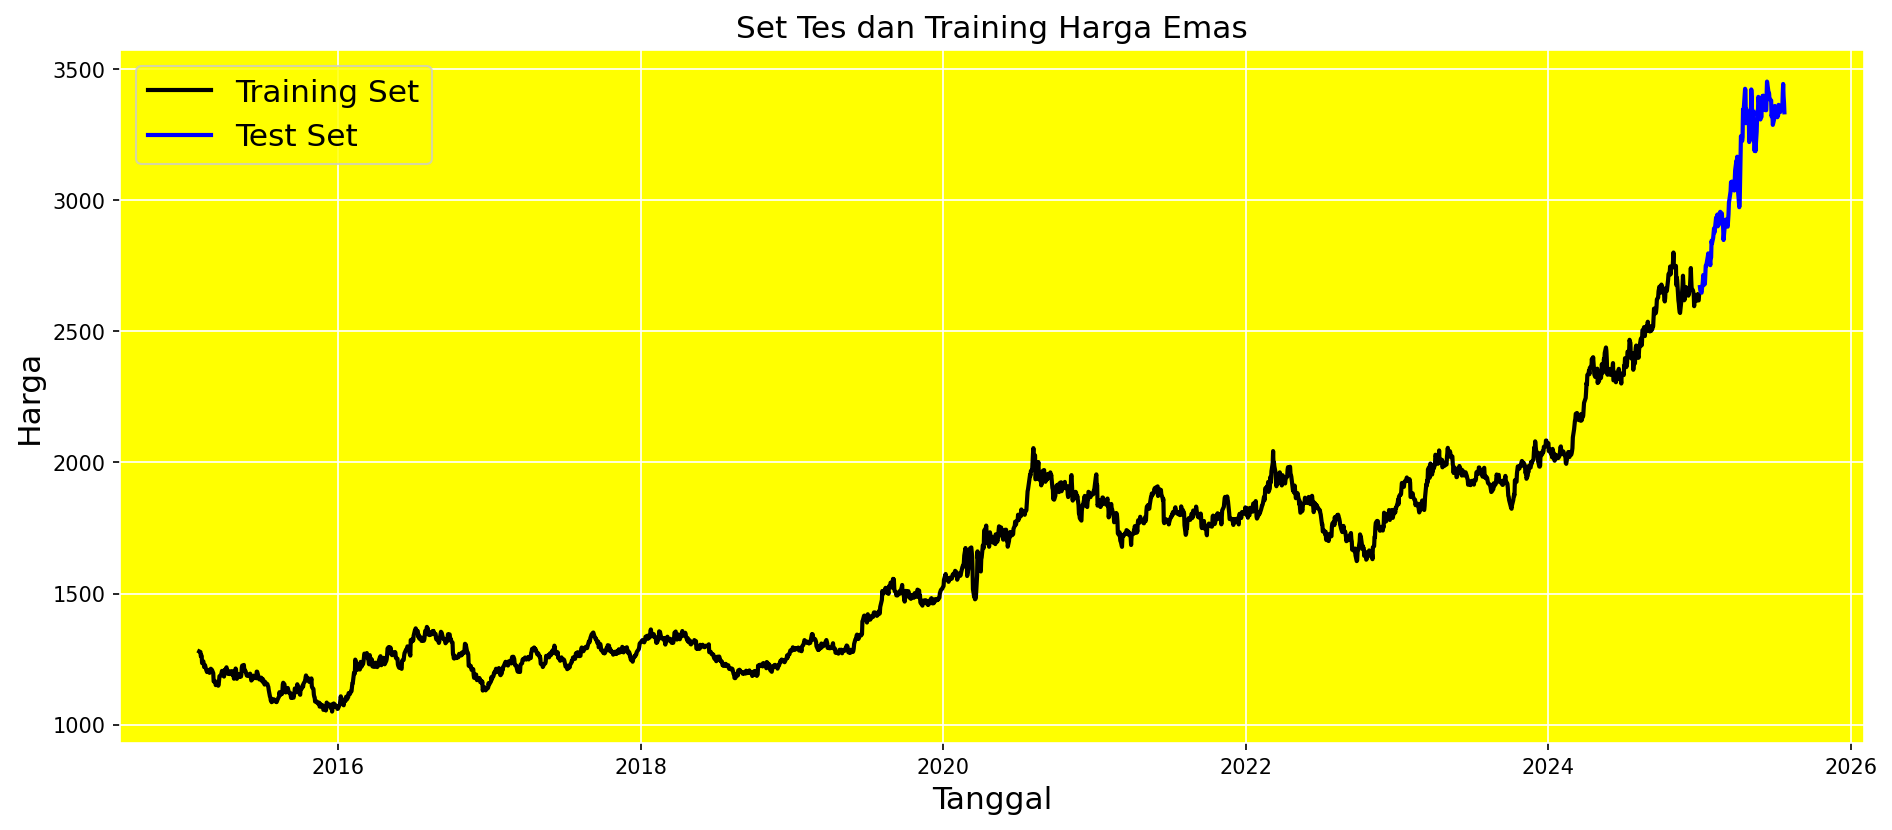

In [19]:
plt.figure(figsize=(15,6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes', edgecolor='white')
plt.plot(df.Tanggal[:-test_size], df.Terakhir[:-test_size], color ='black',lw = 2)
plt.plot(df.Tanggal[-test_size:],df.Terakhir[-test_size:], color = 'blue',lw = 2)
plt.title('Set Tes dan Training Harga Emas',fontsize = 15)
plt.xlabel('Tanggal',fontsize = 15)
plt.ylabel('Harga',fontsize = 15)
plt.legend(['Training Set','Test Set'],loc ='upper left',prop={'size':15})
plt.grid(color = 'white')

In [20]:
features = ['Perubahan%','SMA_20','EMA_12']
target = 'Terakhir'

X_train = df[features].iloc[:-test_size]
X_test = df[features].iloc[-test_size:]

y_train = df[target].iloc[:-test_size]
y_test = df[target].iloc[-test_size:]

In [21]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_testing_scaled = scaler_x.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))


In [22]:
window_size = 60

In [23]:
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, window_size)
X_test, y_test = create_sequences(X_testing_scaled, y_test_scaled, window_size)


In [24]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2485, 60, 3)
y_train shape: (2485, 1)
X_test shape: (86, 60, 3)
y_test shape: (86, 1)


In [25]:
print("X_train_scaled min:", X_train_scaled.min())
print("X_train_scaled max:", X_train_scaled.max())

print("y_train_scaled min:", y_train_scaled.min())
print("y_train_scaled max:", y_train_scaled.max())

X_train_scaled min: 0.0
X_train_scaled max: 1.0
y_train_scaled min: 0.0
y_train_scaled max: 0.9999999999999999


In [26]:
model = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=100, return_sequences=False),
    Dropout(0.2),
    Dense(units=50, activation='relu'),
    Dense(units=1)
])


model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='mse',
    metrics=['mae']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,101 (496.49 KB)

 Trainable params: 127,101 (496.49 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
early_stop = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)


history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - loss: 0.0421 - mae: 0.1325 - val_loss: 0.0124 - val_mae: 0.1027 - learning_rate: 3.0000e-04
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 0.0022 - mae: 0.0338 - val_loss: 0.0039 - val_mae: 0.0478 - learning_rate: 3.0000e-04
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0017 - mae: 0.0305 - val_loss: 0.0069 - val_mae: 0.0699 - learning_rate: 3.0000e-04
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.0016 - mae: 0.0297 - val_loss: 0.0086 - val_mae: 0.0805 - learning_rate: 3.0000e-04
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.0014 - mae: 0.0275 - val_loss: 0.0090 - val_mae: 0.0837 - learning_rate: 3.0000e-04
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 0.0014 - mae: 0.0278 - val_loss: 0.0113 - val_mae: 0.0971 - learning_rate: 3.0000e-04
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0012 - mae: 0.0262
Epoch 7: ReduceLROnPlateau reducing 

In [28]:
# Jika loss sudah flat, tidak perlu lanjut training
final_loss = history.history['loss'][-1]
best_loss = np.min(history.history['loss'])
improvement = ((best_loss - final_loss) / best_loss) * 100

print(f"Final improvement: {improvement:.2f}%")
if abs(improvement) < 1.0:  # Kurang dari 1% improvement
    print("Model sudah converge")

Final improvement: 0.00%
Model sudah converge


In [29]:
result = model.evaluate(X_test,y_test)
y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0052 - mae: 0.0576
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


In [30]:
MAPE = mean_absolute_percentage_error(y_test,y_pred)
Accuracy = 1 - MAPE

In [31]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: [0.003867922117933631, 0.04783954098820686]
Test MAPE: 0.036835401797698245
Test Accuracy: 0.9631645982023017


In [32]:
y_predict_scaled = model.predict(X_test)
y_predict = scaler_y.inverse_transform(y_predict_scaled)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1,1))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


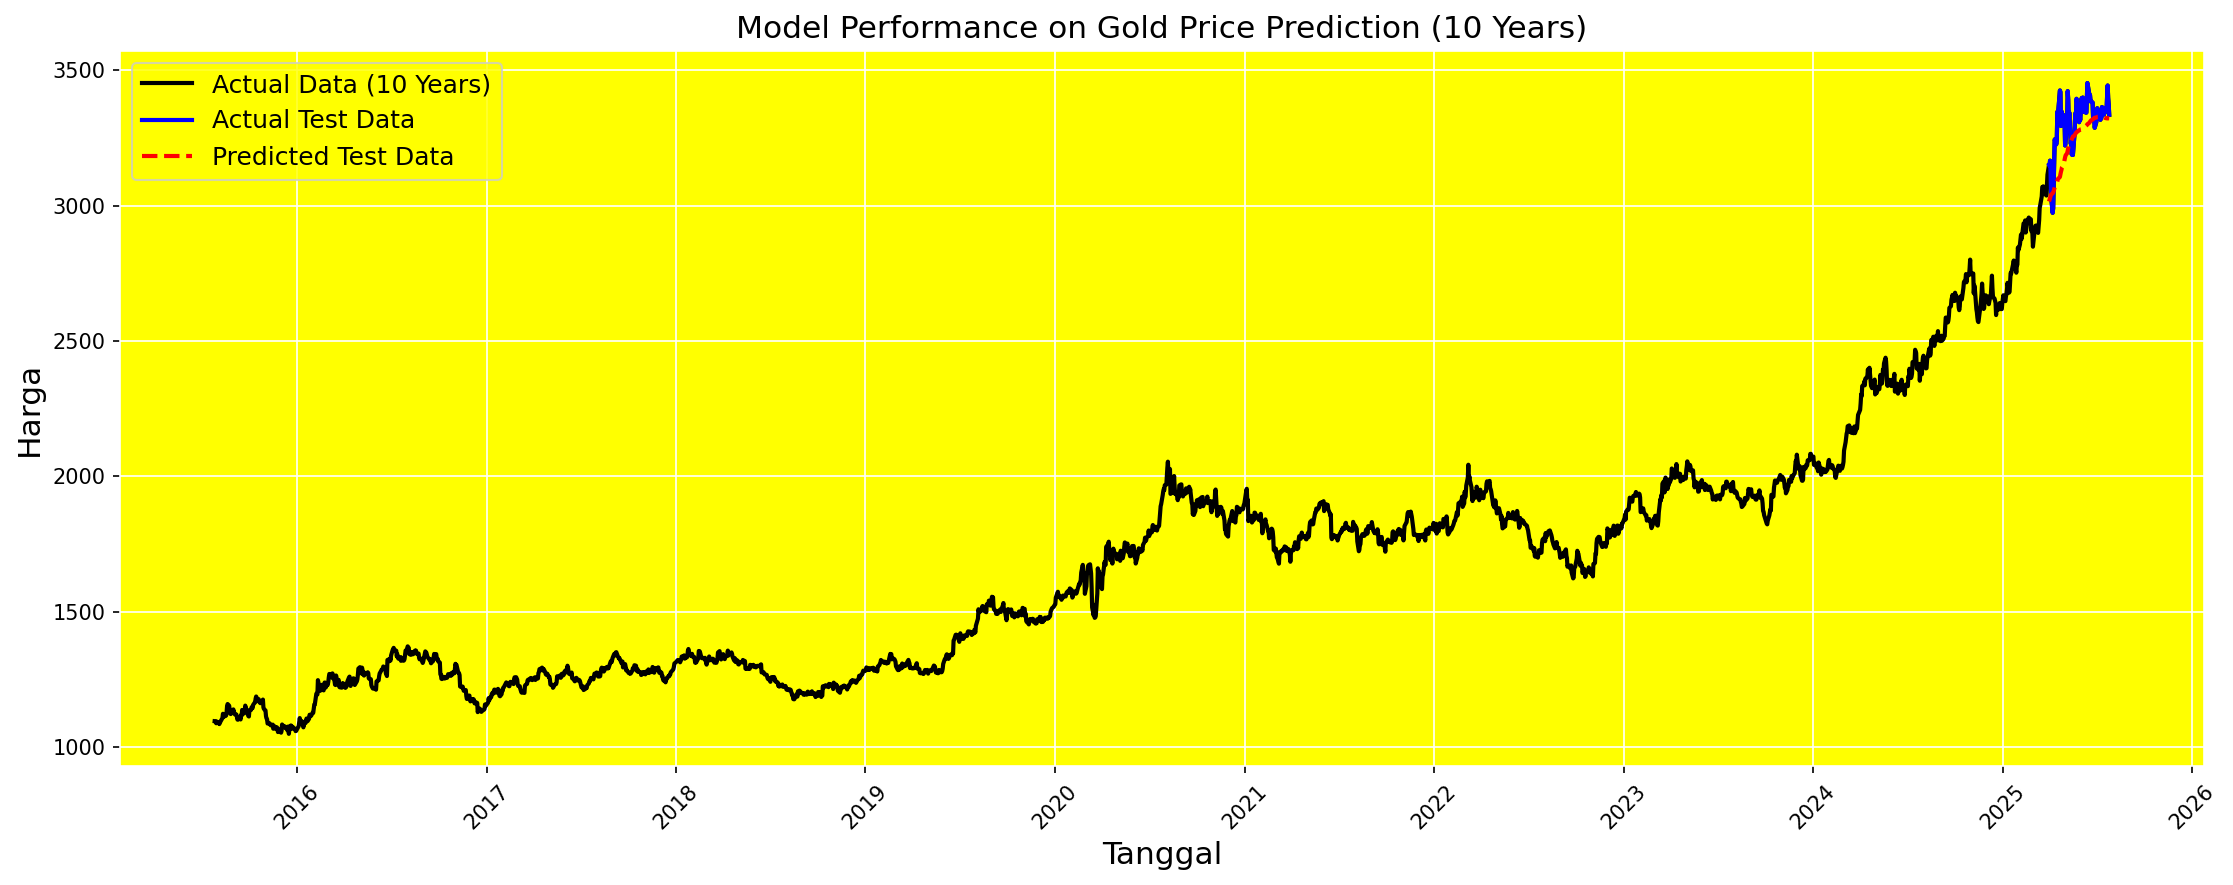

In [33]:
plt.figure(figsize=(15,6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes', edgecolor='white')

# Cari tanggal mulai (10 tahun sebelum tanggal terakhir)
last_date = df.Tanggal.iloc[-1]
start_date = last_date - pd.DateOffset(years=10)

# Filter data untuk 10 tahun terakhir
mask = df.Tanggal >= start_date
recent_data = df[mask]

# Plot data aktual 10 tahun terakhir
plt.plot(recent_data.Tanggal, recent_data.Terakhir, color='black', lw=2, label='Actual Data (10 Years)')

# Plot test data dan prediksi
test_mask = recent_data.Tanggal.isin(df.Tanggal[-86:])
test_dates = recent_data.Tanggal[test_mask]
test_actual = y_test_inv.flatten()
test_predicted = y_predict.flatten()

plt.plot(test_dates, test_actual, color='blue', lw=2, label='Actual Test Data')
plt.plot(test_dates, test_predicted, color='red', lw=2, linestyle='--', label='Predicted Test Data')

plt.title('Model Performance on Gold Price Prediction (10 Years)', fontsize=15)
plt.xlabel('Tanggal', fontsize=15)
plt.ylabel('Harga', fontsize=15)
plt.legend(loc='upper left', prop={'size': 12})
plt.grid(color='white')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
# Buat DataFrame untuk plotting
plot_data = pd.DataFrame({
    'Tanggal': df.Tanggal[-86:],
    'Actual_Test_Data': y_test_inv.flatten(),
    'Predicted_Test_Data': y_predict.flatten()
})

# Plot dengan Plotly Express
fig = px.line(plot_data, x='Tanggal', y=['Actual_Test_Data', 'Predicted_Test_Data'],
              title='Model Performance on Gold Price Prediction',
              labels={'value': 'Harga', 'variable': 'Legend', 'Tanggal': 'Tanggal'})

# Customize layout
fig.update_layout(
    width=1500,
    height=600,
    plot_bgcolor='yellow',
    paper_bgcolor='white',
    font=dict(size=15),
    legend=dict(
        title=None,
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='left',
        x=0
    )
)

# Customize line styles
fig.update_traces(
    selector=dict(name='Actual_Test_Data'),
    line=dict(color='blue', width=2)
)
fig.update_traces(
    selector=dict(name='Predicted_Test_Data'),
    line=dict(color='red', width=2, dash='dash')
)

# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white')

fig.show()

In [40]:
def generate_weekday_dates(start_date, num_days):
    """
    Generate tanggal weekday (Senin-Jumat) saja
    """
    dates = []
    current_date = start_date
    days_added = 0

    while days_added < num_days:
        current_date += timedelta(days=1)
        # Skip weekend (Sabtu=5, Minggu=6)
        if current_date.weekday() < 5:  # 0-4 = Senin-Jumat
            dates.append(current_date)
            days_added += 1

    return dates

# Generate 7 hari weekday ke depan
last_date = df['Tanggal'].iloc[-1]
future_dates = generate_weekday_dates(last_date, 7)

print("Prediksi untuk 7 hari weekday ke depan:")
for date in future_dates:
    print(date.strftime('%Y-%m-%d (%A)'))

Prediksi untuk 7 hari weekday ke depan:
2025-07-28 (Monday)
2025-07-29 (Tuesday)
2025-07-30 (Wednesday)
2025-07-31 (Thursday)
2025-08-01 (Friday)
2025-08-04 (Monday)
2025-08-05 (Tuesday)


In [41]:
def predict_future_weekdays(model, last_sequence, scaler_x, scaler_y, steps=7):
    """
    Memprediksi beberapa steps ke depan (weekdays only)
    """
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(steps):
        # Predict next step
        scaled_pred = model.predict(current_sequence.reshape(1, -1, current_sequence.shape[1]))

        # Inverse transform prediction
        pred = scaler_y.inverse_transform(scaled_pred)[0][0]
        predictions.append(pred)

        # Update sequence untuk prediction berikutnya
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1, 0] = scaler_y.transform([[pred]])[0][0]

    return np.array(predictions)

# Dapatkan sequence terakhir dari data test
last_sequence = X_test[-1]

# Prediksi 7 hari weekday ke depan
future_predictions = predict_future_weekdays(model, last_sequence, scaler_x, scaler_y, steps=7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


In [45]:
# Ambil data historical 30 hari weekday terakhir
historical_mask = df['Tanggal'] >= (last_date - timedelta(days=45))
historical_weekdays = df[historical_mask]
historical_weekdays = historical_weekdays[historical_weekdays['Tanggal'].dt.weekday < 5]
historical_weekdays = historical_weekdays.tail(30)

# Gabungkan data
future_plot_df = pd.DataFrame({
    'Tanggal': list(historical_weekdays['Tanggal']) + future_dates,
    'Harga': list(historical_weekdays['Terakhir']) + list(future_predictions),
    'Type': ['Historical'] * len(historical_weekdays) + ['Predicted'] * len(future_dates)
})

# Plot
fig = px.line(future_plot_df, x='Tanggal', y='Harga', color='Type',
              title='Prediksi Harga Emas 7 Hari Weekday ke Depan',
              labels={'Harga': 'Harga', 'Tanggal': 'Tanggal'})

fig.update_layout(
    width=1500,
    height=600,
    plot_bgcolor='yellow',
    paper_bgcolor='white',
    font=dict(size=15)
)

fig.update_traces(
    selector=dict(name='Historical'),
    line=dict(color='blue', width=2)
)
fig.update_traces(
    selector=dict(name='Predicted'),
    line=dict(color='red', width=2, dash='dash')
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white')

fig.show()

In [43]:
# Alternatif tanpa tabulate
future_df = pd.DataFrame({
    'No': range(1, 8),
    'Tanggal': future_dates,
    'Hari': [date.strftime('%A') for date in future_dates],
    'Predicted_Price': future_predictions
})

print("Prediksi Harga Emas 7 Hari Weekday ke Depan:")
print(future_df.to_string(index=False))

Prediksi Harga Emas 7 Hari Weekday ke Depan:
 No    Tanggal      Hari  Predicted_Price
  1 2025-07-28    Monday      3322.785889
  2 2025-07-29   Tuesday      3326.732666
  3 2025-07-30 Wednesday      3331.369141
  4 2025-07-31  Thursday      3335.990967
  5 2025-08-01    Friday      3340.352539
  6 2025-08-04    Monday      3343.884766
  7 2025-08-05   Tuesday      3346.362549
